# Simulate stochastic process

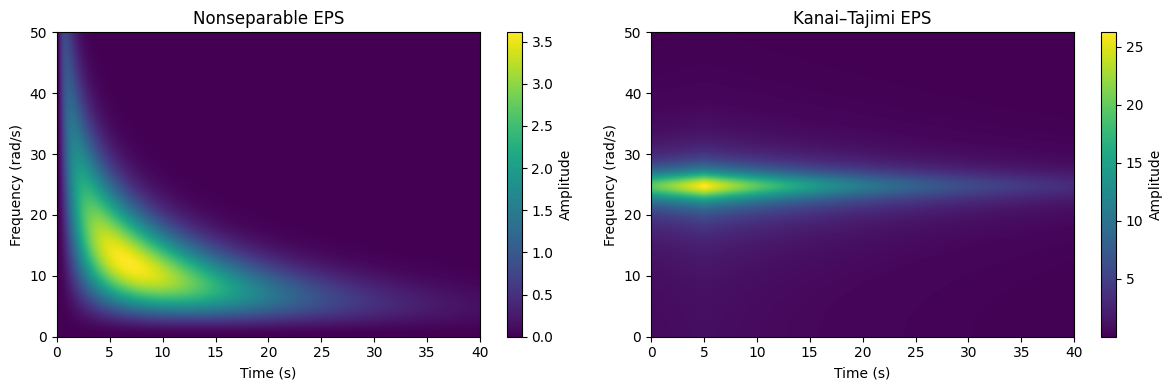

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 40, 1024)
freq = np.linspace(0, 50, 1024)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.15

#KT parameter
omega_g = 25
zeta_g = 0.1

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

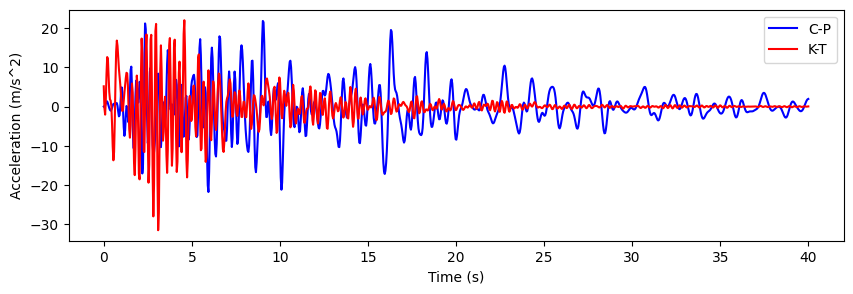

In [ ]:
from simulate_process import simulate_process

w_cp = np.zeros((len(time), len(time)))
w_kt = np.zeros((len(time), len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq)/2, omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['NP', 'K-T'])
plt.show()

In [8]:
import pandas as pd

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [1]:
import numpy as np
import pandas as pd
from wavelet.get_band_options import ghw_band_options

#EPSs parameters
S0 = 1
b0 = 0.15

#KT parameter
omega_g = 25
zeta_g = 0.1

df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.2f} Hz")
print(f"Max dt = {max(dt):.4f} s")

# Uniform bands
uniform_bands, adaptive_bands, freqs = ghw_band_options(x, fs, bins_per_band=4, spike_prominence=1e-1)

Estimated fs = 25.58 Hz
Max dt = 0.0391 s


In [2]:
from wavelet.ghw_transform import ghw_transform

# Apply GHW
out_uniform = ghw_transform(x, fs, uniform_bands, analytic=True, return_downsampled=False)
out_adaptive = ghw_transform(x, fs, adaptive_bands, analytic=True, return_downsampled=False)

# Extract coefficients and bands from ghw_transform output
coeffs = out_uniform["complex"]    # list of arrays per band
bands = out_uniform["bands"]       # (flo, fhi) Hz

num_bands = len(coeffs)

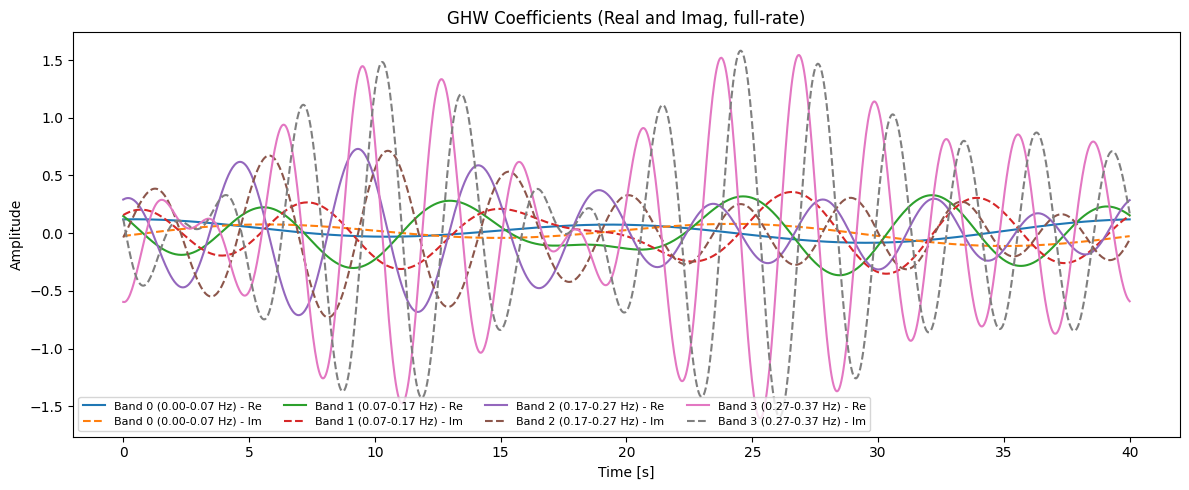

In [3]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 40, 1024)
dt = time[1] - time[0]
t_original = np.arange(len(x)) * dt

plt.figure(figsize=(12,5))
n_bands_to_plot = 4 

for i in range(min(n_bands_to_plot, len(coeffs))):
    c = coeffs[i]
    plt.plot(t_original, c.real, label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Re")
    plt.plot(t_original, c.imag, "--", label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Im")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GHW Coefficients (Real and Imag, full-rate)")
plt.legend(fontsize=8, ncol=n_bands_to_plot)
plt.tight_layout()
plt.show()

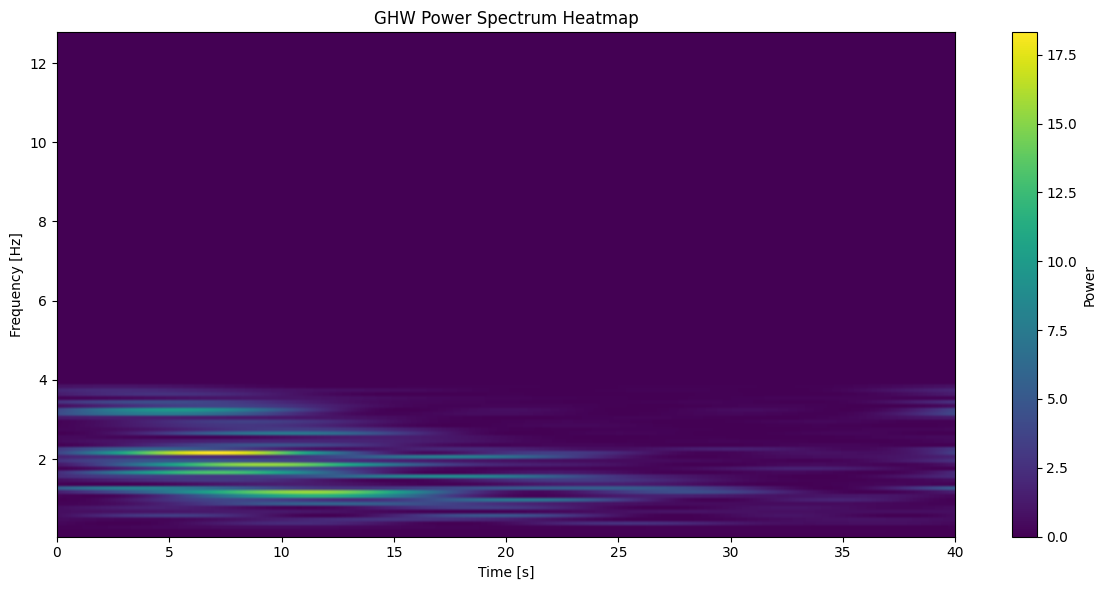

In [4]:
import numpy as np
import matplotlib.pyplot as plt

power_matrix = np.array([np.abs(c)**2 for c in coeffs])  # shape (num_bands, N)

t_original = np.arange(len(x)) * dt  # full time vector
freq_centers = np.array([(b[0]+b[1])/2 for b in bands])  # center freq per band

plt.figure(figsize=(12,6))
plt.imshow(power_matrix, aspect='auto', origin='lower',
           extent=[t_original[0], t_original[-1], freq_centers[0], freq_centers[-1]])
plt.colorbar(label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("GHW Power Spectrum Heatmap")
plt.tight_layout()
plt.show()

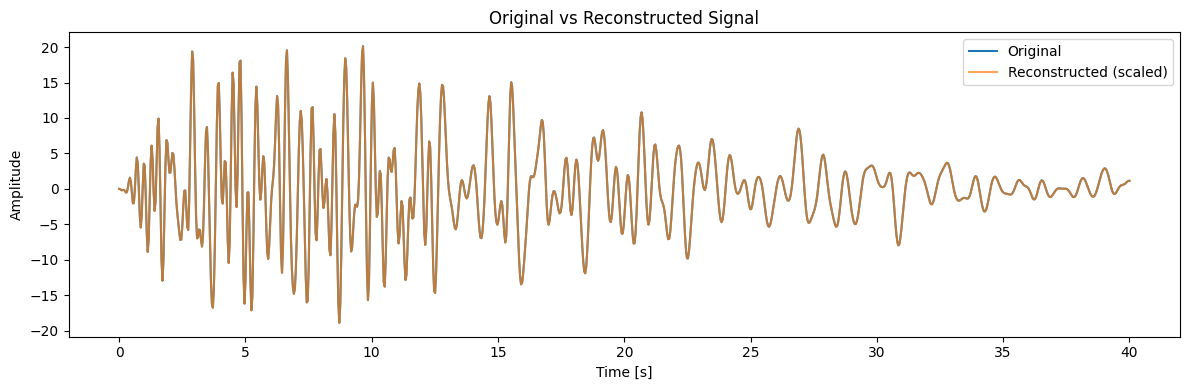

In [5]:
x_rec = out_uniform["reconstruct_fullrate"]()

# Scale to match original signal RMS
scale = np.std(x) / np.std(x_rec)
x_rec_scaled = x_rec * scale

plt.figure(figsize=(12,4))
plt.plot(t_original, x, label="Original", alpha=1)
plt.plot(t_original, x_rec_scaled, label="Reconstructed (scaled)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.tight_layout()
plt.show()
